# KDD Cup 99 Intrusion Detection

In [ ]:
# Installing Packages
!pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

In [ ]:
# Importing required library for path handling
import os

# Importing kagglehub for downloading dataset
import kagglehub

# Importing required libraries
import pandas as pd
import numpy as np

# Importing visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importing ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest

In [ ]:
# Downloading latest version of dataset
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

# Printing dataset folder path
print("Path to dataset files:", path)

100%|██████████| 87.8M/87.8M [00:00<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/galaxyh/kdd-cup-1999-data/versions/1


In [ ]:
# Listing all downloaded files
files_list = os.listdir(path)
print("Files inside dataset folder:\n", files_list)

Files inside dataset folder:
 ['kddcup.data.corrected', 'corrected', 'kddcup.newtestdata_10_percent_unlabeled.gz', 'kddcup.testdata.unlabeled.gz', 'kddcup.newtestdata_10_percent_unlabeled', 'training_attack_types', 'typo-correction.txt', 'kddcup.data', 'kddcup.names', 'kddcup.data_10_percent.gz', 'corrected.gz', 'kddcup.testdata.unlabeled_10_percent', 'kddcup.data_10_percent_corrected', 'kddcup.testdata.unlabeled_10_percent.gz', 'kddcup.data.gz', 'kddcup.testdata.unlabeled', 'kddcup.data_10_percent']


In [ ]:
# Selecting dataset file
target_file_labeled = "kddcup.data_10_percent.gz"
DATA_PATH = os.path.join(path, target_file_labeled)
print("Using labeled dataset file:", DATA_PATH)

Using labeled dataset file: /root/.cache/kagglehub/datasets/galaxyh/kdd-cup-1999-data/versions/1/kddcup.data_10_percent.gz


In [ ]:
# Defining dataset configuration
KDD_COLUMNS = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"]

In [ ]:
# Defining helper functions
def loading_kdd_data(file_path: str, columns: list) -> pd.DataFrame:
    if file_path.endswith(".gz"):
        df = pd.read_csv(file_path, names=columns, compression="gzip")
    else:
        df = pd.read_csv(file_path, names=columns)
    return df

def printing_basic_overview(df: pd.DataFrame) -> None:
    # Printing dataset shape
    print("\nDataset Shape:", df.shape)

    # Printing dataset info
    print("\nDataset Info:")
    print(df.info())

    # Printing first few rows
    print("\nDataset Preview (Head):")
    print(df.head())

    # Printing summary stats for numeric columns
    print("\nNumerical Summary:")
    print(df.describe())

    # Printing missing values
    print("\nMissing Values Count:")
    print(df.isnull().sum())


def plotting_label_distribution(df: pd.DataFrame, target_col: str) -> None:
    # Plotting label distribution
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=target_col)
    plt.title("Label Frequency Distribution")
    plt.xticks(rotation=90)
    plt.xlabel("Attack Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def plotting_categorical_distributions(df: pd.DataFrame, categorical_cols: list) -> None:
    # Plotting distributions for each categorical column
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col)
        plt.title(f"Category Distribution: {col}")
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


def plotting_protocol_traffic(df: pd.DataFrame) -> None:
    # Creating protocol-based traffic summary
    traffic_df = df.groupby("protocol_type")["label"].count().reset_index(name="counting")
    print("\nProtocol Traffic Summary:\n", traffic_df)

    # Plotting bar chart for protocol traffic
    plt.figure(figsize=(7, 4))
    sns.barplot(data=traffic_df, x="protocol_type", y="counting")
    plt.title("Connections Count by Protocol Type")
    plt.xlabel("Protocol")
    plt.ylabel("Connections")
    plt.tight_layout()
    plt.show()


def plotting_correlation_heatmap(df: pd.DataFrame) -> None:
    # Computing correlation matrix for numeric columns only
    corr = df.select_dtypes(include=[np.number]).corr()

    # Plotting correlation heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", linewidths=0.3)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()


def encoding_categorical_features(df: pd.DataFrame, columns_to_encode: list) -> pd.DataFrame:
    # Copying dataset to avoid modifying original reference
    encoded_df = df.copy()

    # Initialising label encoder
    encoder = LabelEncoder()

    # Encoding categorical columns one by one
    for col in columns_to_encode:
        encoded_df[col] = encoder.fit_transform(encoded_df[col])

    return encoded_df


def splitting_data(df: pd.DataFrame, target_col: str, test_size: float = 0.30, seed: int = 42):
    # Separating features and target variable
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    # Printing split sizes
    print("\nTrain/Test Split Details:")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    return X_train, X_test, y_train, y_test


def evaluating_classifier(model_name: str, y_true, y_pred) -> float:
    # Calculating accuracy
    acc = accuracy_score(y_true, y_pred) * 100

    # Printing model results
    print(f"\nModel Evaluation: {model_name}")
    print(f"Accuracy: {acc:.2f}%")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    return acc


def plotting_confusion(y_true, y_pred, title: str) -> None:
    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def plotting_model_comparison(names: list, scores: list) -> None:
    # Plotting model accuracy comparison
    plt.figure(figsize=(7, 4))
    plt.bar(names, scores)
    plt.title("Classifier Accuracy Comparison")
    plt.xlabel("Model")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


def running_isolation_forest(X_train: pd.DataFrame, X_test: pd.DataFrame) -> pd.DataFrame:
    # Initialising isolation forest model
    anomaly_model = IsolationForest(random_state=42, contamination="auto")

    # Fitting model on training set
    anomaly_model.fit(X_train)

    # Predicting anomalies on test set (-1 means anomaly)
    anomaly_flags = anomaly_model.predict(X_test)

    # Extracting anomalous samples
    anomaly_df = X_test[anomaly_flags == -1].copy()

    # Printing anomalies count
    print("\nAnomaly Detection Results:")
    print("Total anomalies detected:", anomaly_df.shape[0])
    return anomaly_df

def plotting_feature_importance(model, feature_names: list, title: str) -> None:
    # Checking if model supports feature importance
    if not hasattr(model, "feature_importances_"):
        print(f"\n{title}: Feature importance not available for this model.")
        return

    # Creating importance dataframe
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)

    # Plotting top important features
    plt.figure(figsize=(10, 7))
    sns.barplot(data=imp_df.head(15), x="Importance", y="Feature")
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [ ]:
# Loading KDD dataset using KaggleHub path
data = loading_kdd_data(DATA_PATH, KDD_COLUMNS)

# Printing dataset overview
printing_basic_overview(data)

# Printing label distribution counts
print("\nLabel Value Counts:\n", data["label"].value_counts())


Dataset Shape: (494021, 42)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromise

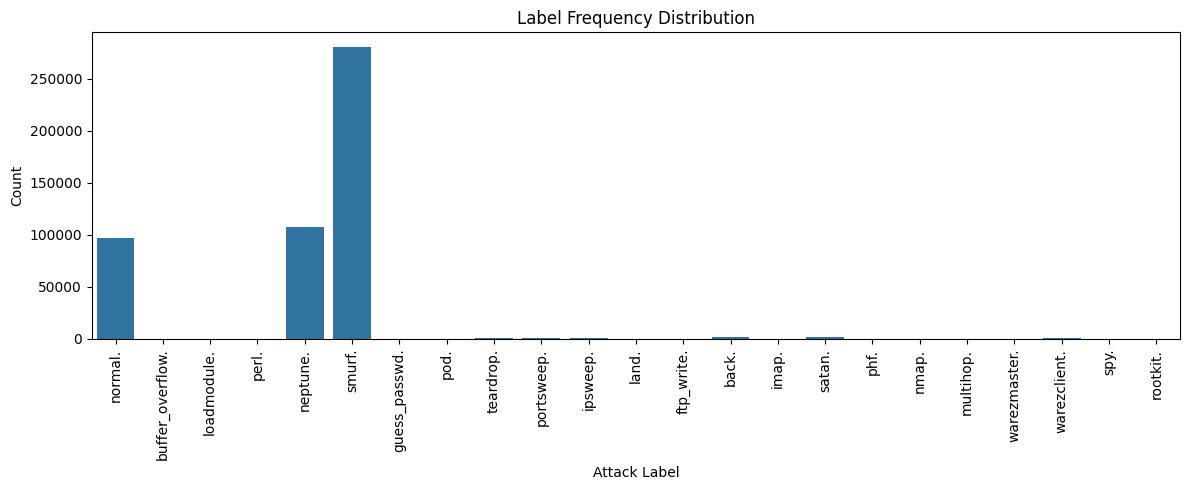

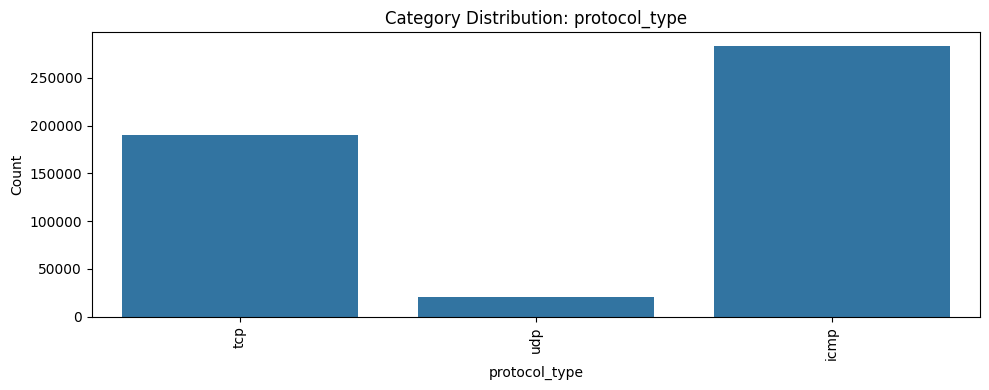

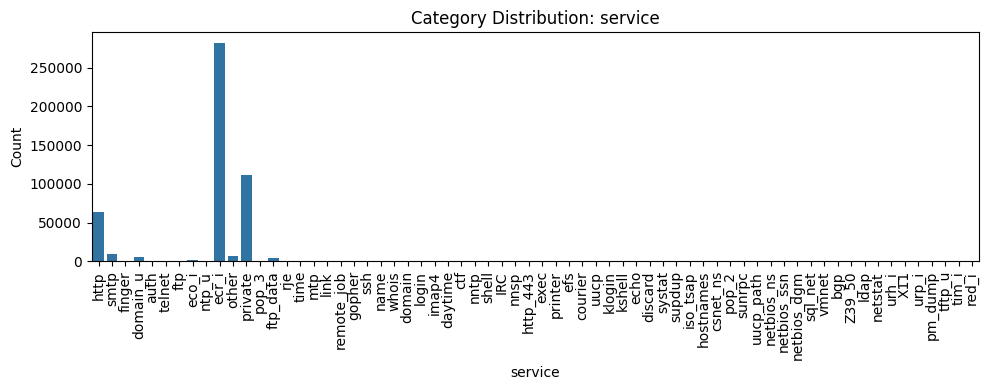

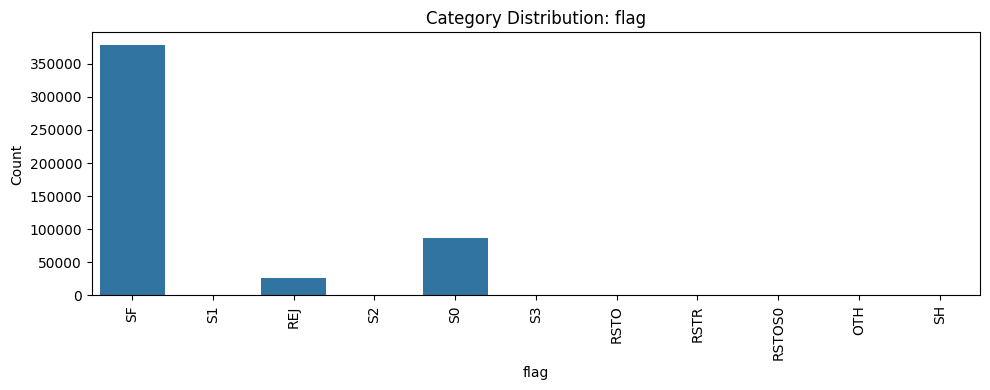

In [ ]:
# Plotting label distribution
plotting_label_distribution(data, "label")

# Plotting categorical distributions
categorical_cols = ["protocol_type", "service", "flag"]
plotting_categorical_distributions(data, categorical_cols)


Protocol Traffic Summary:
   protocol_type  counting
0          icmp    283602
1           tcp    190065
2           udp     20354


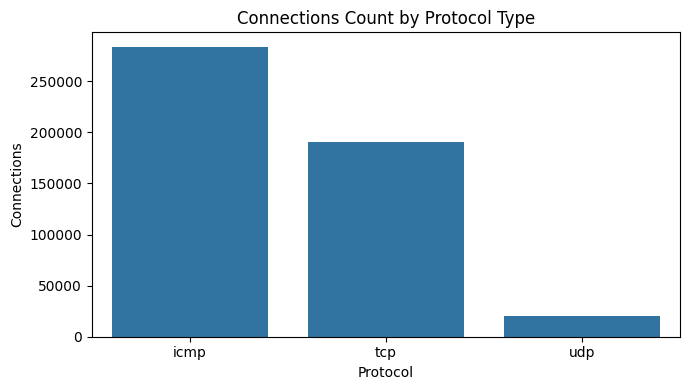

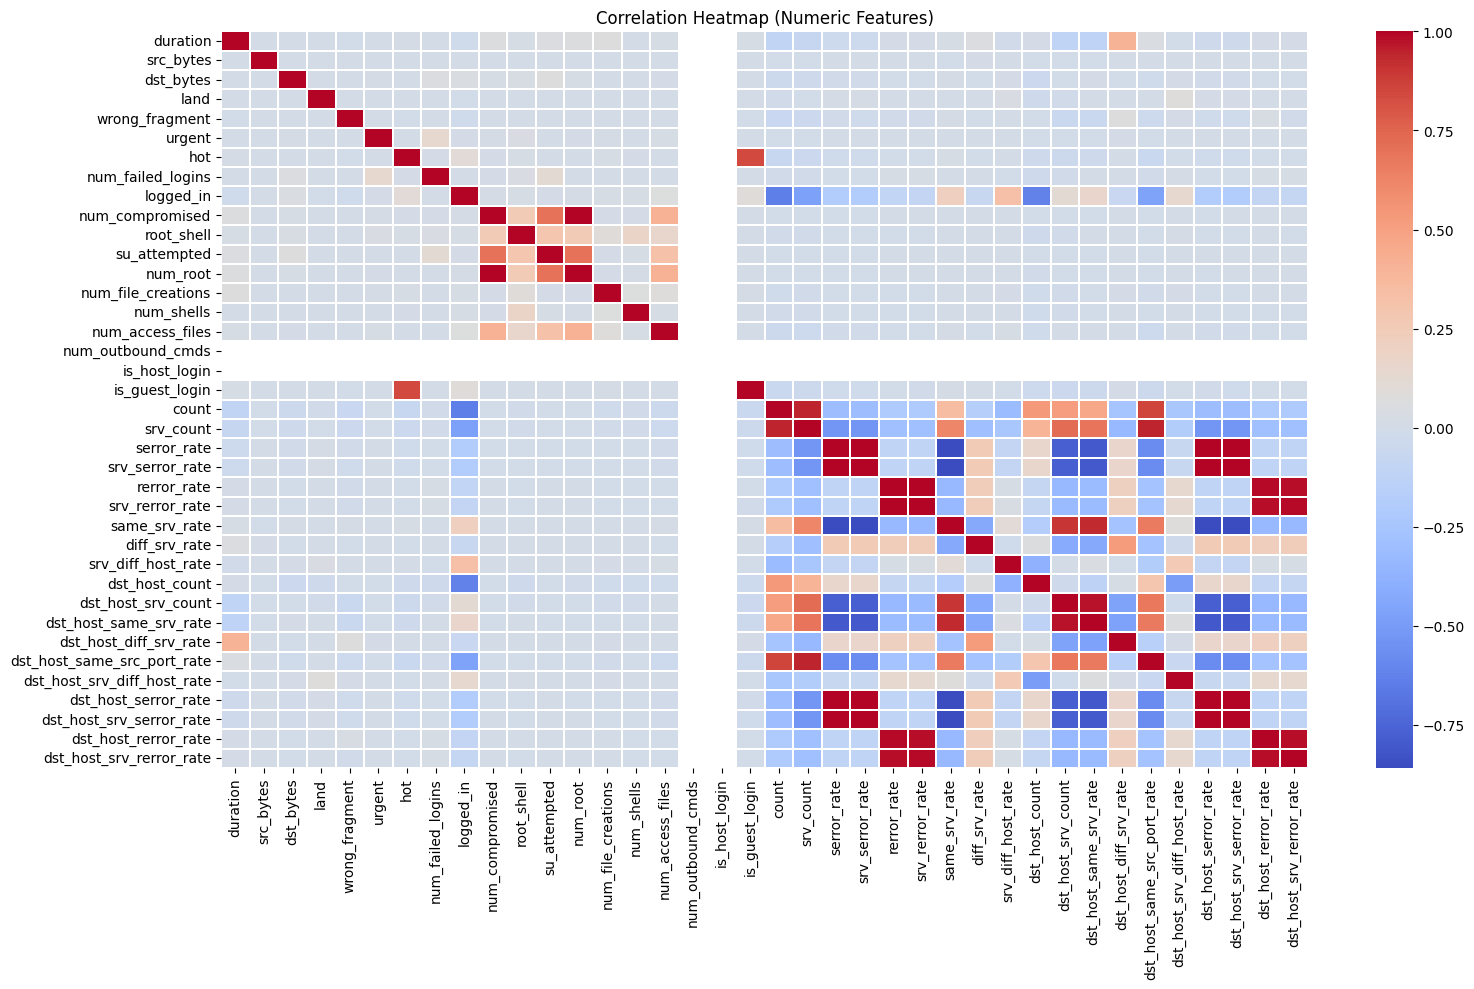

In [ ]:
# Plotting protocol traffic analysis
plotting_protocol_traffic(data)

# Plotting correlation heatmap
plotting_correlation_heatmap(data)

In [ ]:
# Encoding categorical columns including label
data_encoded = encoding_categorical_features(data, ["protocol_type", "service", "flag", "label"])

# Splitting dataset into train/test
X_train, X_test, y_train, y_test = splitting_data(data_encoded, target_col="label", test_size=0.30, seed=42)


Train/Test Split Details:
X_train shape: (345814, 41)
X_test shape: (148207, 41)
y_train shape: (345814,)
y_test shape: (148207,)



Model Evaluation: Random Forest
Accuracy: 99.98%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       661
           1       0.64      0.78      0.70         9
           2       0.00      0.00      0.00         2
           3       1.00      0.94      0.97        16
           4       1.00      0.75      0.86         4
           5       1.00      0.99      0.99       374
           6       1.00      1.00      1.00         6
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     32160
          10       1.00      0.97      0.99        69
          11       1.00      1.00      1.00     29184
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00        79
          15       1.00      1.00      1.00       312
      

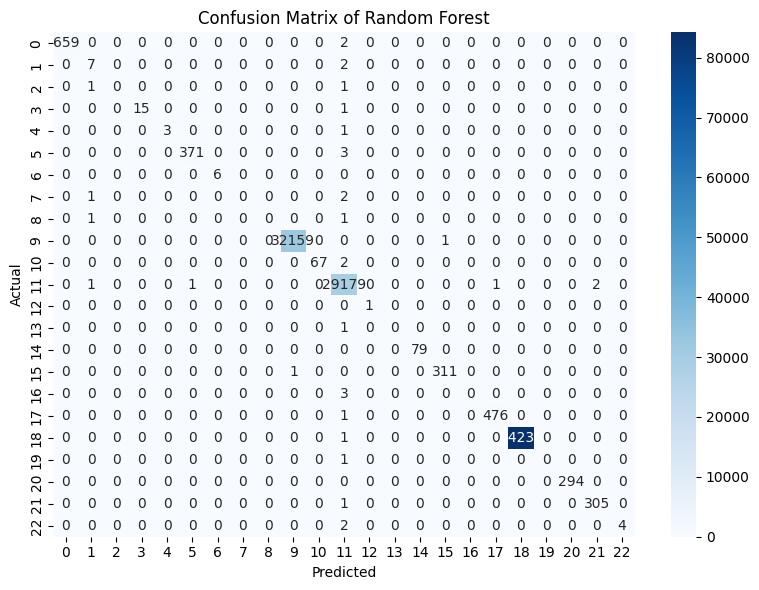

In [ ]:
# Training Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluating Random Forest model
rf_acc = evaluating_classifier("Random Forest", y_test, rf_pred)
plotting_confusion(y_test, rf_pred, "Confusion Matrix of Random Forest")


Model Evaluation: Decision Tree
Accuracy: 99.95%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       661
           1       0.70      0.78      0.74         9
           2       0.00      0.00      0.00         2
           3       1.00      0.94      0.97        16
           4       0.60      0.75      0.67         4
           5       0.99      0.99      0.99       374
           6       0.86      1.00      0.92         6
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     32160
          10       0.97      0.96      0.96        69
          11       1.00      1.00      1.00     29184
          12       0.50      1.00      0.67         1
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00        79
          15       0.99      0.98      0.99       312
      

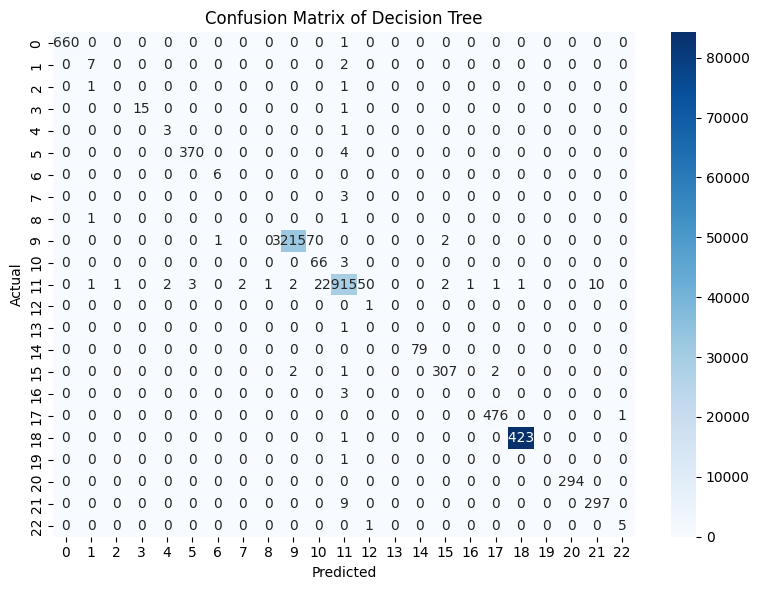

In [ ]:
# Training Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Evaluating Decision Tree model
dt_acc = evaluating_classifier("Decision Tree", y_test, dt_pred)
plotting_confusion(y_test, dt_pred, "Confusion Matrix of Decision Tree")

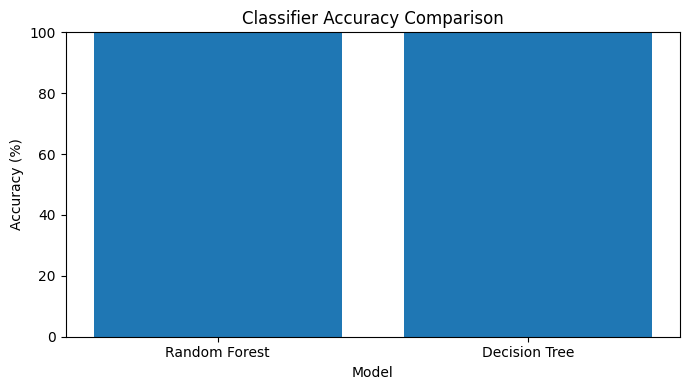

In [ ]:
# Comparing model accuracy
plotting_model_comparison(["Random Forest", "Decision Tree"], [rf_acc, dt_acc])

In [ ]:
# Running anomaly detection
anomaly_data = running_isolation_forest(X_train, X_test)


Anomaly Detection Results:
Total anomalies detected: 19448


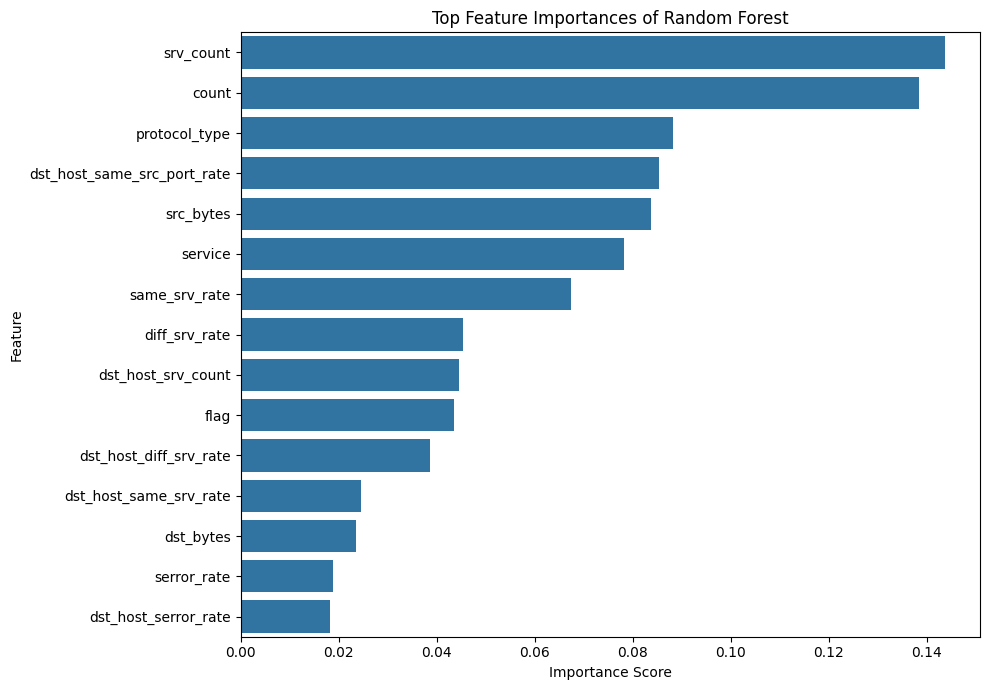

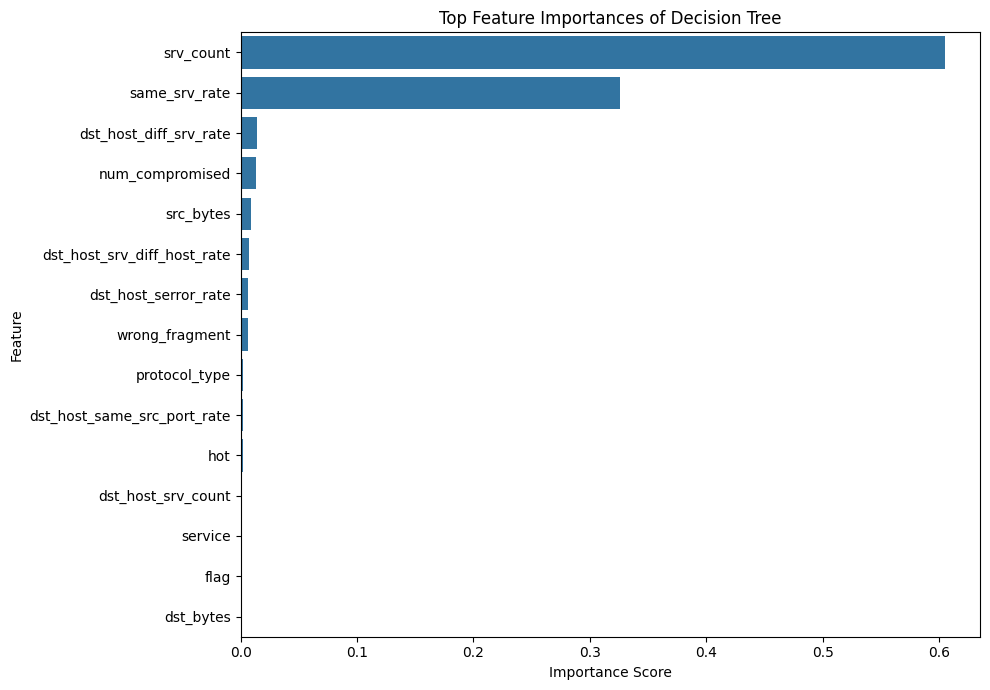

In [ ]:
# Plotting feature importances
plotting_feature_importance(rf_model, X_train.columns.tolist(), "Top Feature Importances of Random Forest")
plotting_feature_importance(dt_model, X_train.columns.tolist(), "Top Feature Importances of Decision Tree")